# **Amazon stars reviews prediction - NLP**

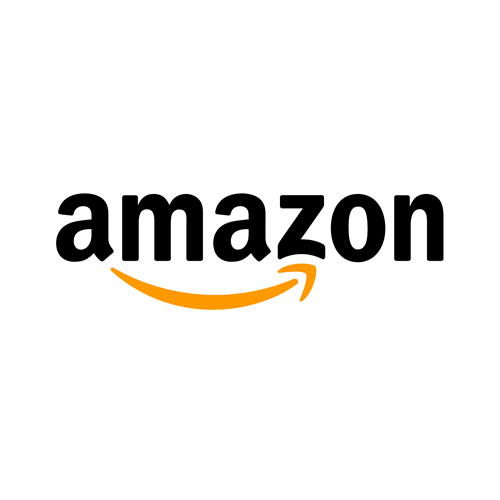

# Data Intake

In [ ]:
!python -m spacy download es_core_news_sm
#Reiniciar kernel una vez instalada esta librería

In [1]:
import itertools
import nltk
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
data = pd.read_json('/content/drive/MyDrive/NLP PROJECT/dataset_es_train.json',lines= True)

In [ ]:
#data= pd.read_json('C://Users//nacho//repositorios//Acamica//data//dataset_es_train.json',lines= True)

In [ ]:
print(data.shape)
data.head()

### **Objetivo:**

Implementar un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente.

# **1- EDA**

### **Data Understanding**

In [ ]:
print('Columns ' , data.columns)
print('Sahpe ', data.shape)
print('Data Types:  ',data.dtypes)

Columns  Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')
Sahpe  (200000, 8)
Data Types:   review_id           object
product_id          object
reviewer_id         object
stars                int64
review_body         object
review_title        object
language            object
product_category    object
dtype: object


In [ ]:
data.describe(include='all')

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
count,200000,200000,200000,200000.000000,200000,200000,200000,200000
unique,200000,150938,179076,NaN,198264,112114,1,30
top,es_0558711,product_es_0261843,reviewer_es_0437514,NaN,Buena relación calidad precio,Bien,es,home
freq,1,8,7,NaN,106,1952,200000,26962
mean,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1.414217,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN


**Review_id :** son 200.000 instancias diferentes, por lo que podríamos eliminarla. Habría que investigar si la notación utilizada tiene alguna temporalidad.

In [ ]:
#Review_id
data.review_id.nunique()

200000

**Product_id:** Tenemos 150.938 instancias diferentes.

In [ ]:
#Product_id
data.product_id.nunique()

150938

In [ ]:
frecuencia = data.product_id.value_counts().to_frame('f')
frecuencia['f']= frecuencia['f'].astype(int)
frecuencia=frecuencia.value_counts().to_frame('q')
frecuencia['q']= np.log10(frecuencia['q'])
frecuencia = frecuencia.reset_index()
frecuencia

Text(17.175000000000004, 0.5, 'Log(X)')

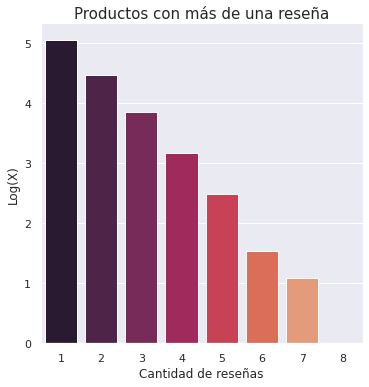

In [ ]:
sns.catplot( x=frecuencia.f, y=frecuencia.q, data=frecuencia, palette='rocket',kind='bar')
plt.title('Productos con más de una reseña',fontsize=15)
plt.xlabel('Cantidad de reseñas')
plt.ylabel('Log(X)')

**Reviewer_id :** al igual que en product_id tenemos muchas instancias de un solo comentario ( 179.076) pero también tenemos gente que ha opinado hasta 7 veces

In [ ]:
data.reviewer_id.nunique()

**Stars:** El target de nuestro modelo. Está perfectamente balanceado-

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 6.799999999999979, 'Estrellas')

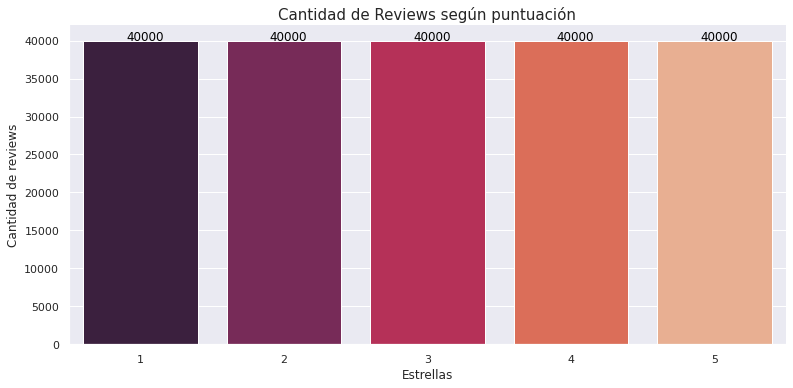

In [ ]:
g=sns.catplot(data.stars.value_counts().index,
              data.groupby('stars').review_id.agg('count'),
              data=data,kind='bar',palette = 'rocket',
              height=5, aspect=18/8.27)

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.3, 
            p.get_height() * 1, 
            "{:.0f}".format(p.get_height()), 
            color='black', rotation='horizontal', size='large')
plt.title('Cantidad de Reviews según puntuación',fontsize=15)
plt.ylabel('Cantidad de reviews')
plt.xlabel('Estrellas')

In [ ]:
data.stars.isna().sum()

0

No hay faltantes en nuestro target

**Product_category**

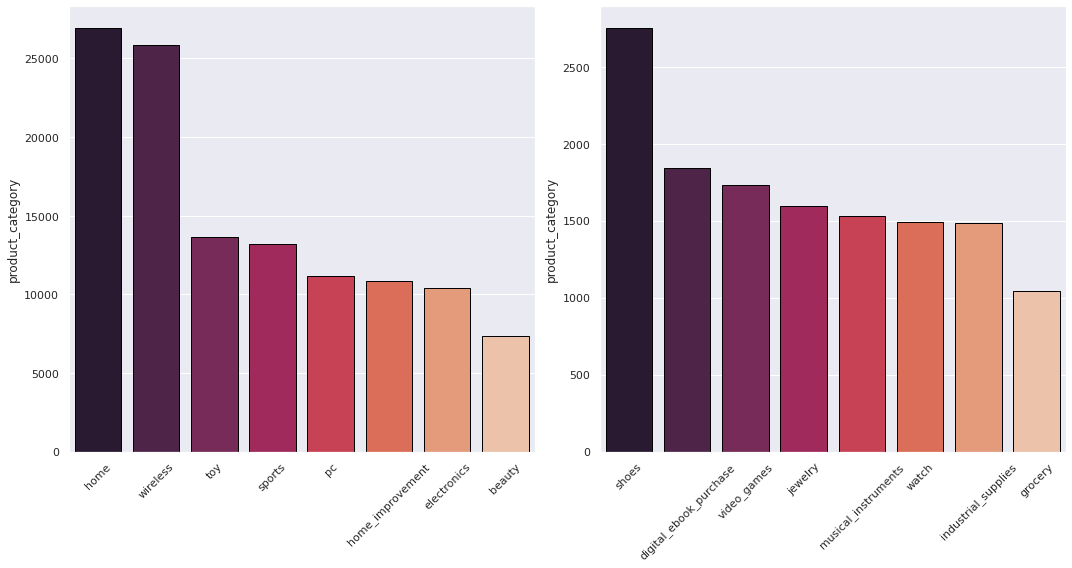

In [ ]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
sns.barplot(x =data.product_category.value_counts().iloc[:8].index,
                   y=  data.product_category.value_counts().iloc[:8],
                   data = data,palette = 'rocket', edgecolor ='black')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(x =data.product_category.value_counts().iloc[-8:].index,
                   y=  data.product_category.value_counts().iloc[-8:],
                   data = data,palette = 'rocket', edgecolor ='black')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

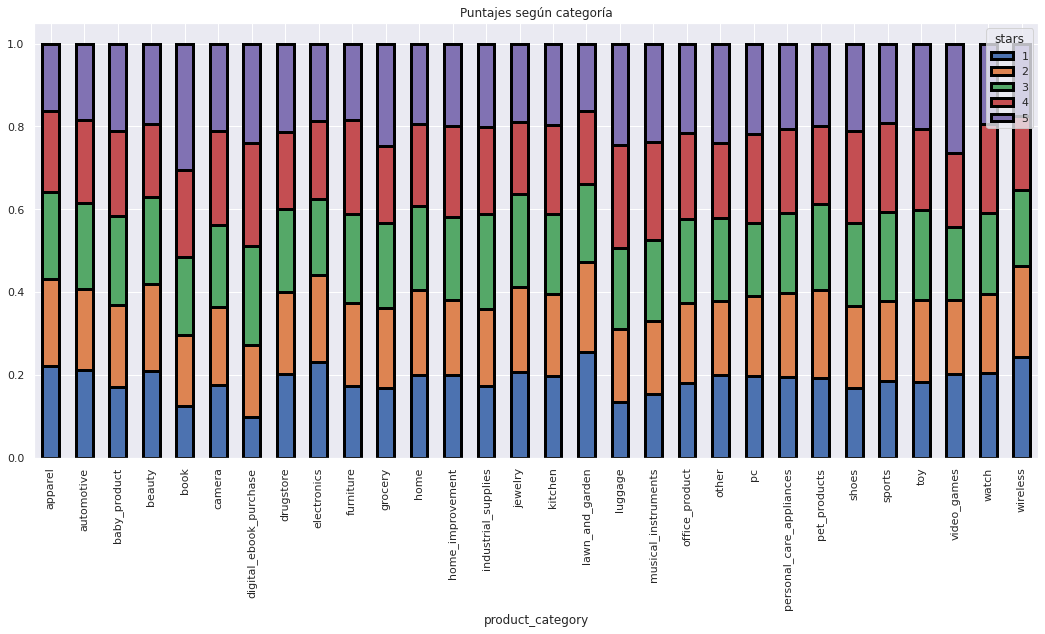

In [ ]:
#plt.figure(figsize=(14,8))
data_stars_pct = (data.groupby(['product_category','stars'])['stars'].count()/data.groupby(['product_category'])['stars'].count())
data_stars_pct.unstack().plot.bar(stacked=True, figsize=(18, 8), title = 'Puntajes según categoría', edgecolor='black',linewidth=3);



Target muy balanceado a lo largo de las clases

### **Exploración del dataset**

In [ ]:
#Observar comentarios aleatoriamente 
index_random = np.random.randint(0,high = data.shape[0])
comentario = data.iloc[index_random].review_body
estrella =  data.iloc[index_random].stars
titulo = data.iloc[index_random].review_title
categoria = data.iloc[index_random].product_category
print(index_random)
print(estrella)
print(categoria)
print(titulo)
print(comentario)

54218
2
beauty
No es lo que esperaba
El producto no funciona demasiado bien en difusores de aire frio. Apenas desprende olor. No es lo que esperaba .


## Basic Feature Extraction

Primero, analicemos cuantas palabras hay en cada comentario, y veamos cual es el promedio de palabras por estrella. Puede que sea un buen feature para el modelo.

In [ ]:
df1= pd.concat([data.review_body,data.stars],axis=1)

In [ ]:
df1['word_count'] = df1['review_body'].apply(lambda x: len(str(x).split(" ")))
df1.head()

,review_body,stars,word_count
0,Nada bueno se me fue ka pantalla en menos de 8...,1,19
1,"Horrible, nos tuvimos que comprar otro porque ...",1,23
2,Te obligan a comprar dos unidades y te llega s...,1,22
3,"No entro en descalificar al vendedor, solo pue...",1,60
4,Llega tarde y co la talla equivocada,1,7


In [ ]:
print('Promdio de Palabras para comentarios con 1 estrella = ',df1.loc[df1.stars == 1].word_count.mean())
print('Promdio de Palabras para comentarios con 2 estrella = ',df1.loc[df1.stars == 2].word_count.mean())
print('Promdio de Palabras para comentarios con 3 estrella = ',df1.loc[df1.stars == 3].word_count.mean())
print('Promdio de Palabras para comentarios con 4 estrella = ',df1.loc[df1.stars == 4].word_count.mean())
print('Promdio de Palabras para comentarios con 5 estrella = ',df1.loc[df1.stars == 5].word_count.mean())

Promdio de Palabras para comentarios con 1 estrella =  28.470575
Promdio de Palabras para comentarios con 2 estrella =  31.293075
Promdio de Palabras para comentarios con 3 estrella =  28.8229
Promdio de Palabras para comentarios con 4 estrella =  25.878525
Promdio de Palabras para comentarios con 5 estrella =  24.533275


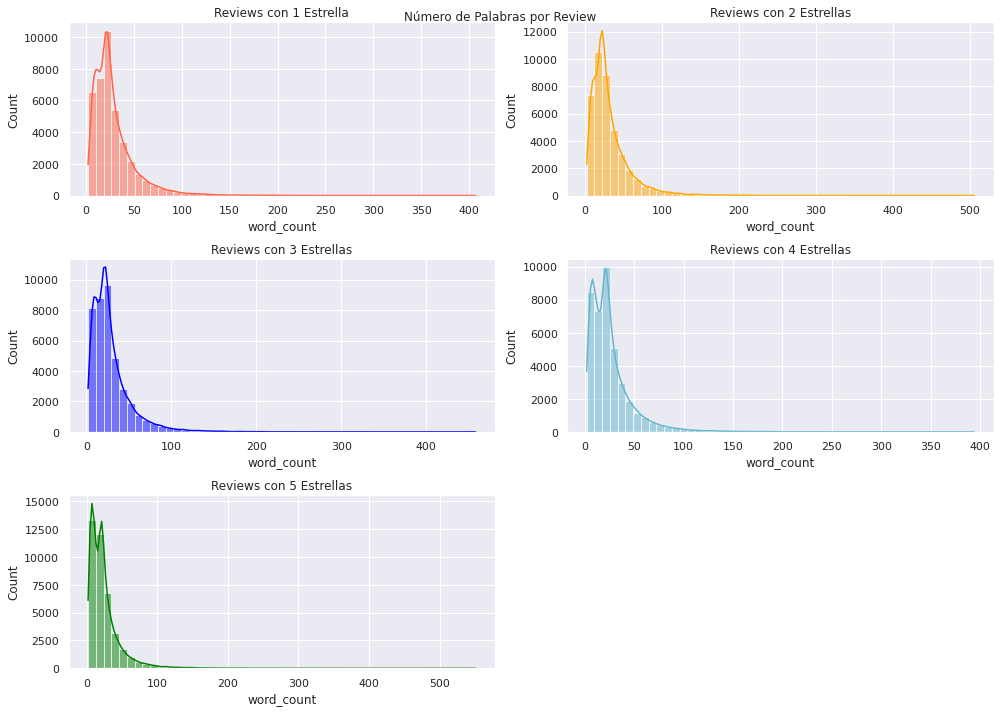

In [ ]:
fig,axes = plt.subplots(3,2,figsize=(14,10))
axes = axes.flatten()

data_1_star = df1[df1['stars']==1]
sns.histplot(ax = axes[0], data= data_1_star, x ='word_count', color= 'tomato', bins = 50, kde=True)
axes[0].set_title('Reviews con 1 Estrella')

data_2_star = df1[df1['stars']==2]
sns.histplot(ax = axes[1], data= data_2_star, x ='word_count', color= 'orange', bins = 50, kde=True)
axes[1].set_title('Reviews con 2 Estrellas')

data_3_star = df1[df1['stars']==3]
sns.histplot(ax = axes[2], data= data_3_star, x ='word_count', color= 'blue', bins = 50, kde=True)
axes[2].set_title('Reviews con 3 Estrellas')

data_4_star = df1[df1['stars']==4]
sns.histplot(ax = axes[3], data= data_4_star, x ='word_count', color= 'c', bins = 50, kde=True)
axes[3].set_title('Reviews con 4 Estrellas')

data_5_star = df1[df1['stars']==5]
sns.histplot(ax = axes[4], data=data_5_star, x='word_count', color= 'green', bins = 50, kde=True)
axes[4].set_title('Reviews con 5 Estrellas')

# Se eliminan los axes vacios
for i in [5]:
    fig.delaxes(axes[i])
    
fig.suptitle('Número de Palabras por Review')
plt.tight_layout()
plt.show()

De momento no hay gran margen de análisis para la cantidad de palabraspor comentario. Se muestran las distribuciones y son todas muy semejantes

## **Filtración y análisis de frecuencias**

### 1- Dataset con los comentarios positivos ( de 4 y 5 estrellas)

In [ ]:
#Saco palabras que no aportan un gran valor semánitico
filtrar = ['es','el','muy','la','los','lo','me','si','no','se']

In [ ]:
positivo = data[data.stars > 3]
positivo.shape

In [ ]:
resenas = []
for i in range(positivo.shape[0]):
  comentario = positivo.iloc[i].review_body
  comentario = clean_text_round1(comentario)
  comentario = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(comentario)
  comentario = [word for word in comentario if word not in stopwords]
  comentario = [word for word in comentario if word not in filtrar]

  resenas.append(comentario)

In [ ]:
resenas = list(itertools.chain(*resenas))
resenas[0:10]

In [ ]:
freq_positivo = nltk.FreqDist(resenas)
freq_positivo

In [ ]:
palabras_positivas = pd.DataFrame(list(freq_positivo.items()),columns=['Palabra','Frecuencia'])
palabras_positivas.sort_values('Frecuencia',ascending=False, inplace = True)
palabras_positivas.reset_index(drop = True, inplace=True)
palabras_positivas.head()

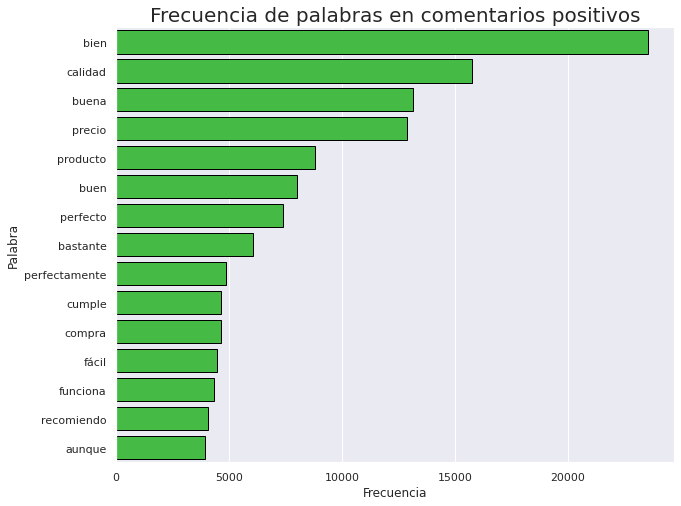

In [ ]:
plt.figure(figsize = (10,8))
plot = sns.barplot(y  = palabras_positivas.iloc[:15].Palabra, 
                   x = palabras_positivas.iloc[:15].Frecuencia ,
                   color = 'limegreen', edgecolor ='black' )
for item in plot.get_yticklabels():
    item.set_rotation(0)
plt.title('Frecuencia de palabras en comentarios positivos',fontsize = 20)
plt.show()

### 2- Dataset con los comentarios neutros( 3 estrellas)

In [ ]:
neutro = data[data.stars ==3]
neutro.shape  

In [ ]:
resenas = []
for i in range(neutro.shape[0]):
  comentario = neutro.iloc[i].review_body
  comentario = clean_text_round1(comentario)
  comentario = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(comentario)
  comentario = [word for word in comentario if word not in stopwords]
  comentario = [word for word in comentario if word not in filtrar]
  resenas.append(comentario)

In [ ]:
resenas = list(itertools.chain(*resenas))
resenas[0:10]

In [ ]:
freq_neutro = nltk.FreqDist(resenas)
freq_neutro

In [ ]:
palabras_neutras = pd.DataFrame(list(freq_neutro.items()),columns=['Palabra','Frecuencia'])
palabras_neutras.sort_values('Frecuencia',ascending=False, inplace = True)
palabras_neutras.reset_index(drop = True, inplace=True)
palabras_neutras.head()

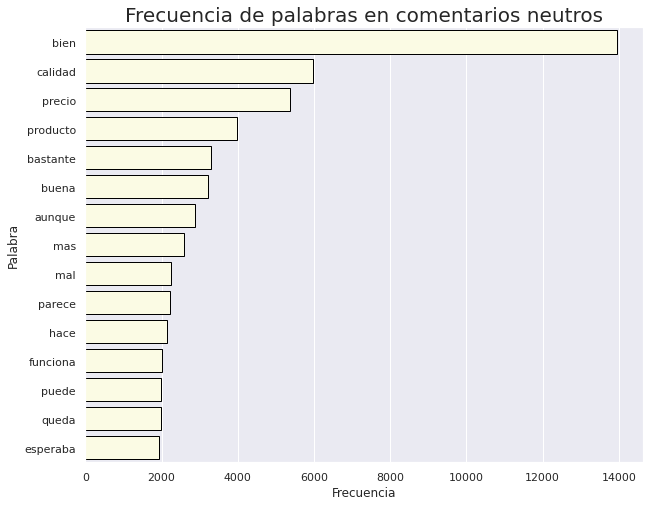

In [ ]:

plt.figure(figsize = (10,8))
plot = sns.barplot(y  = palabras_neutras.iloc[:15].Palabra,
                   x = palabras_neutras.iloc[:15].Frecuencia ,
                   color = 'lightyellow', edgecolor ='black' )
for item in plot.get_xticklabels():
    item.set_rotation(0)
plt.title('Frecuencia de palabras en comentarios neutros', fontsize=20)
plt.show()


### 3- Dataset con los comentarios negativos( 1 y 2 estrellas)

In [ ]:
negativo = data[data.stars < 3]
negativo.shape

In [ ]:
resenas = []
for i in range(negativo.shape[0]):
  comentario = negativo.iloc[i].review_body
  comentario = clean_text_round1(comentario)
  comentario = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(comentario)
  comentario = [word for word in comentario if word not in stopwords]
  comentario = [word for word in comentario if word not in filtrar]
  resenas.append(comentario)

In [ ]:
resenas = list(itertools.chain(*resenas))
resenas[0:10]

In [ ]:
freq_negativo = nltk.FreqDist(resenas)
freq_negativo

In [ ]:
palabras_negativas = pd.DataFrame(list(freq_negativo.items()),columns=['Palabra','Frecuencia'])
palabras_negativas.sort_values('Frecuencia',ascending=False, inplace = True)
palabras_negativas.reset_index(drop = True, inplace=True)
palabras_negativas.head()

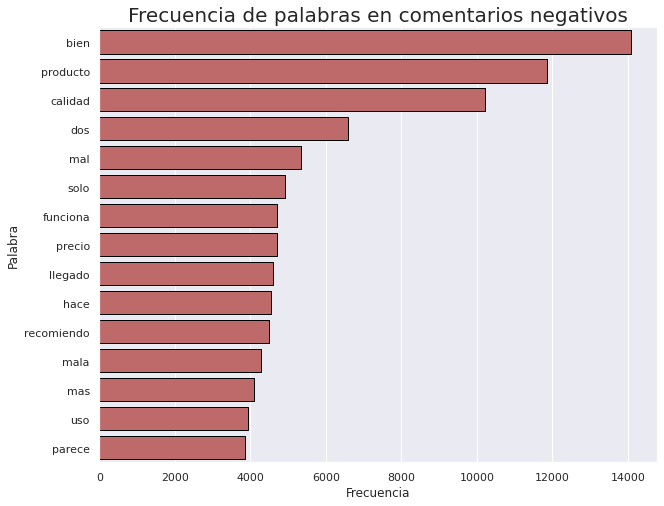

In [ ]:
plt.figure(figsize = (10,8))
plot = sns.barplot(y  = palabras_negativas.iloc[:15].Palabra, 
                   x = palabras_negativas.iloc[:15].Frecuencia
                   ,color='indianred', edgecolor ='black' )
for item in plot.get_xticklabels():
    item.set_rotation(0)
plt.title('Frecuencia de palabras en comentarios negativos', fontsize=20)
plt.show()

# **2 - Normalización**

##**Introducción**

Para normalizar generaré 3 tipos de datos normalizados:

1. Data normalizada a través de eliminación de RegEx, emoticones, emojis, stopwords y palabras menores de 3 letras.

2. La Data del punto 1, pero le agregamos la técnica de Stemming de la nltk

3. La Data del punto 1, pero le agregamos la técnica de Lemmatizacion de spaCy

## **Train, Test y Dev**

In [ ]:
import gc

In [ ]:
# Importamos dataset de desarrollo
data_dev = pd.read_json('/content/drive/MyDrive/NLP PROJECT/dataset_es_dev.json', lines = True)
print("- Cantidad de filas del set de " + color.YELLOW + "desarrollo" + color.END + ":", data_dev.shape[0])

# Importamos dataset de entrenamiento
data_train = pd.read_json('/content/drive/MyDrive/NLP PROJECT/dataset_es_train.json', lines = True)
print("- Cantidad de filas del set de " + color.CYAN + "entrenamiento" + color.END + ":", data_train.shape[0])

# Importamos dataset de prueba
data_test = pd.read_json('/content/drive/MyDrive/NLP PROJECT/dataset_es_test.json', lines = True)
print("- Cantidad de filas del set de " + color.GREEN + "prueba" + color.END + ":", data_test.shape[0])

- Cantidad de filas del set de desarrollo: 5000
- Cantidad de filas del set de entrenamiento: 200000
- Cantidad de filas del set de prueba: 5000


Concatenamos todos los datasets

In [ ]:
# Concatenamos todos
data = pd.concat([data_dev,data_train,data_test])
data = data.reset_index(drop=True)
data.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
209995,es_0685611,product_es_0919143,reviewer_es_0461769,5,Para lo que cuesta es perfecto porque cumple s...,Perfectos para lo que sirven,es,wireless
209996,es_0638242,product_es_0636134,reviewer_es_0214562,5,"Material muy flexible y cómodo, acorde a la de...","Buen vendedor, rápido y fiable.",es,wireless
209997,es_0760108,product_es_0078583,reviewer_es_0043609,5,Se ve bien el grabado,medallas con bonito grabado,es,home
209998,es_0070806,product_es_0359350,reviewer_es_0258717,5,lo compré para mi bici pero finalmente se lo h...,timbre,es,sports
209999,es_0794544,product_es_0130307,reviewer_es_0651938,5,Pues este tipo de cascos si que son inalambric...,Auriculares sin cables de verdad,es,electronics


In [ ]:
# Liberamos espacio de memoria
del(data_dev)
del(data_train)
del(data_test)
gc.collect()

64

##**Funciones**


### **1- Función de limpieza de RegEx**

In [ ]:
import re
import string

def clean_text_round1(text):
   text = text.lower()
   text = re.sub('\[.*?¿\]\%', ' ', text)
   text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
   text = re.sub('\w*\d\w*', '', text)
   text = re.sub('[‘’“”…«»]', '', text)
   text = re.sub('\n', ' ', text)
   
   return text

### **2- Eliminación de tildes.**

In [ ]:
def basic_text_cleanup(text):
    """
    Convert to lowercase, remove punctuation, remove digits
    """
    text = text.lower() #lower case
    text = re.sub("[^\w|\s]", " ",text) #replace non word and non space characters by a space
    text = re.sub("\s+", " ",text) #remove extra spaces
    text = re.sub("á", "a",text) #saco acentos
    text = re.sub("é", "e",text) #saco acentos
    text = re.sub("í", "i",text) #saco acentos
    text = re.sub("ó", "o",text) #saco acentos
    text = re.sub("ú", "u",text) #saco acentos
    text = re.sub(",", "",text) #saco comas
    #doc = nlp(text)#convert to a spacy object
    #doc = [w.text for w in doc if not w.is_stop or w.text =="no"] # remove stopwords but keep "no" for bigrams
    #doc = [w for w in doc if (len(w)> 2 or w == "no")] #only words longer than 2 characters
    #doc = [w for w in doc if (len(w)> 2 )] #only words longer than 2 characters
    #doc = [w for w in doc if w != "y"] #remove "y"
    #doc = " ".join(doc)
    return text


In [ ]:
'''#Como aplico lo de arriba? 
data["clean_text"] = data["review_body"].apply(lambda x:basic_text_cleanup(x) )
'''

'#Como aplico lo de arriba? \ndata["clean_text"] = data["review_body"].apply(lambda x:basic_text_cleanup(x) )\n'

In [ ]:
'''from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize

STOP_WORDS = stopwords.words('spanish')

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]

df["token"] = df["normal"].apply(lambda x:tokenize(x))
'''


'from nltk.corpus import stopwords\nfrom nltk import word_tokenize, sent_tokenize\n\nSTOP_WORDS = stopwords.words(\'spanish\')\n\ndef tokenize(x):\n    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>1]\n\ndf["token"] = df["normal"].apply(lambda x:tokenize(x))\n'

In [ ]:
import re
from unicodedata import normalize
def no_acentos(frase):
    # -> NFD y eliminar diacríticos
    frase_sin = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", frase), 0, re.I
        )

    # -> NFC
    return normalize( 'NFC', frase_sin).lower()

### **3- Función de limpieza de emojis**

In [ ]:
#Eliminamos los emojis de los comentarios. Tale como 😜 , 😔 , etc.
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

### **4- Función de limpieza de emoticones**

In [ ]:
!pip install emot


In [ ]:
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

# Remover emoticones tales como :-) , :'( , etc
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

### **5-StopWords modificadas**

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Sacamos algunas palabras del set stopword que queremos conservar en las reviews:
list_a_conservar=['no', 'tuvo', 'poco', 'nada', 'ni', 'mucho', 'muchos', 'contra']
for mant_palabra in list_a_conservar:
    stopwords.remove(mant_palabra)

In [ ]:
# Eliminamos tildes, dierecis, etc de las stopwords.
stopwords = [no_acentos(word) for word in stopwords]

In [ ]:
def eliminar_stopwords(comentario):
    # Eliminamos las palabras de menos de 3 letras
    frase = nltk.word_tokenize(comentario)
    frase_lista = [palabra for palabra in frase if (len(palabra)>2 or palabra in ['no','ni','si','ma'])]
    
    # Sacamos las Stopwords
    frase_lista = [palabra for palabra in frase_lista if not palabra in stopwords ]
    
    # Por ultimo volvemos a unir la lista
    frase = " ".join(frase_lista)
    return frase

## **1- Data Cleaning**

In [ ]:
df = data.copy()
df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [ ]:
#Eliminamos las columnas que no vamos a usar en este proyecto.
df = df.drop(['review_id','product_id','reviewer_id','language','product_category','review_title'],axis=1)

In [ ]:
#Limpiamos el texto según las funciones definidas anteriormente.
df['review_body'] =  df['review_body'].apply(clean_text_round1)
df['review_body'] =  df['review_body'].apply(remove_emoji)
df['review_body'] =  df['review_body'].apply(remove_emoticons)
df['review_body'] =  df['review_body'].apply(basic_text_cleanup)
df['review_body'] =  df['review_body'].apply(eliminar_stopwords)

In [ ]:
df

,stars,review_body
0,1,malisimo grande demasiado aparatoso mal protec...
1,1,no recibido pedido no devolucion
2,1,buscar sistema no funciona bien abrazadera lle...
3,1,utilice brocas menor diametro doblaron varias ...
4,1,no gusta olor viejo aspecto malo
...,...,...
209995,5,cuesta perfecto cumple funcion sobra ademas pe...
209996,5,material flexible comodo acorde descripcion
209997,5,bien grabado
209998,5,compre bici finalmente quedado xiaomi scooter ...


## **2.1- Stemming**

Vamos a crear una base de datos con el proceso de normalización llamado Stemming. Voy a utilizar Snowball Stemmer de la librería NLTK ya que viene con la opción de español.

In [ ]:
df_stemm = df.copy()
df_stemm.head()

,stars,review_body
0,1,malisimo grande demasiado aparatoso mal protec...
1,1,no recibido pedido no devolucion
2,1,buscar sistema no funciona bien abrazadera lle...
3,1,utilice brocas menor diametro doblaron varias ...
4,1,no gusta olor viejo aspecto malo


In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [ ]:
comentario_list=[]
for comentario in df_stemm.review_body:
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    comentario=re.sub("[^a-zA-Z]"," ",str(comentario))
    # Pasamos todo a minúsculas
    comentario=comentario.lower()
    # Tokenizamos para separar las palabras del titular
    comentario=nltk.word_tokenize(comentario)
    # Eliminamos las palabras de menos de 3 letras
    comentario= [palabra for palabra in comentario if len(palabra)>3]
    # Sacamos las Stopwords
    comentario = [palabra for palabra in comentario if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    comentario=[stemmer.stem(palabra) for palabra in comentario]
    # Por ultimo volvemos a unir el titular
    comentario=" ".join(comentario)
    
    # Vamos armando una lista con todos los comentarios
    comentario_list.append(comentario)

In [ ]:
df_stemm["review_body"] = comentario_list
df_stemm.head()

,stars,review_body
0,1,malisim grand demasi aparat protector pantall
1,1,recib ped devolucion
2,1,busc sistem funcion bien abrazader llev agarr ...
3,1,utilic broc menor diametr dobl vari mantequill...
4,1,gust olor viej aspect mal


In [ ]:
df['review_body_stemm']= df_stemm["review_body"]
df.head()

,stars,review_body,review_body_stemm
0,1,malisimo grande demasiado aparatoso mal protec...,malisim grand demasi aparat protector pantall
1,1,no recibido pedido no devolucion,recib ped devolucion
2,1,buscar sistema no funciona bien abrazadera lle...,busc sistem funcion bien abrazader llev agarr ...
3,1,utilice brocas menor diametro doblaron varias ...,utilic broc menor diametr dobl vari mantequill...
4,1,no gusta olor viejo aspecto malo,gust olor viej aspect mal


## **2.2- Lemmatization**

Para la lematización voy a usar la librería spaCy.

In [ ]:
'''
# Previamente
## !python -m spacy download es_core_news_sm
#Si bien ya lo hice antes, uno debe reiniciar el kernel cada vez que instala esta librería

import spacy # https://spacy.io/usage/models
nlp = spacy.load('es_core_news_sm')

#Stop Words de es_core_news_sm
from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

# Quitamos de las stopwords palabras como 'no', 'bueno', 'buena' que nos pueden ser últiles para predecir
stopwords_spacy.remove('no') # En los comentarios negativos es muy repetida
stopwords_spacy.remove('bueno')
stopwords_spacy.remove('buena')
stopwords_spacy.remove('tarde')
stopwords_spacy.remove('temprano')
stopwords_spacy.remove('día')
stopwords_spacy.remove('días')
stopwords_spacy.remove('dia')
stopwords_spacy.remove('dias')
stopwords_spacy.remove('grandes')
stopwords_spacy.remove('general')
'''

In [ ]:
'''
#Constante de signos de puntuación
import string
puntua = string.punctuation + '¡¿...'
excluded_pos = ['SCONJ','CCONJ','NUM','PUNCT','PRON','DET','ADP','AUX','X']
'''

In [ ]:
'''
#Defino una función para lematizar
def text_data_lemma(sentence):
    doc = nlp(sentence)
    
    clean_tokens = []
    for token in doc:
        if (token.pos_ not in excluded_pos and str(token) not in stopwords_spacy and len(token.text)>2): 
            temp = token.lemma_.strip()
            clean_tokens.append(temp.lower())
    
    return clean_tokens
'''

Una vez que está definida la función de lematizar, se la aplicamos al df, para crear una lista con cada uno de los comentarios lematizados.
Es un proceso muy exigente a nivel computacional, por lo que cambiaremos el tipo de entorno de ejecución por una GPU.

La siguiente celda está comentada para no volverse a ejecutar. La operación tuvo un tiempo de 3 horas y 38 minutos.

In [ ]:
# Limpiamos todas las reviews con lemmatizer
# %%time
# reviews_lemma = []
# for i in df.index:
#     rev = text_data_lemma(df.review_body.iloc[i])
#     reviews_lemma.append(" ".join(rev))
# reviews_lemma[:5]

CPU times: user 3h 36min 14s, sys: 2min 37s, total: 3h 38min 51s
Wall time: 3h 38min 20s


Se creó una lista. La transformo a un pandas DataFrame y la descargo para poder trabajar en el futuro.

In [ ]:
#Creo DataFrame a partir de la lista
# df_lemma = pd.DataFrame(reviews_lemma)

In [ ]:
# Almaceno el DF en formato csv dentro de mi Drive
#   df_lemma.to_csv('df_lemma.csv')
#   !cp df_lemma.csv '/content/drive/MyDrive/NLP PROJECT/df_lemma.csv'

In [ ]:
#Descargo desde Google Drive
lemma = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/df_lemma.csv')

In [ ]:
#Asigno nueva columna al df con el que vamos a trabajar
df['review_body_lemma']= lemma['0']
df.tail()

,stars,review_body,review_body_stemm,review_body_lemma
209995,5,cuesta perfecto cumple funcion sobra ademas pe...,cuest perfect cumpl funcion sobr adem pequ cam...,costar perfecto cumplir funcion sobrar pecar c...
209996,5,material flexible comodo acorde descripcion,material flexibl comod acord descripcion,material flexible acorde descripcion
209997,5,bien grabado,bien grab,grabar
209998,5,compre bici finalmente quedado xiaomi scooter ...,compr bici final qued xiaomi scoot pint model ...,comprar bici finalmente quedar xiaomi scooter ...
209999,5,pues tipo cascos inalambricos verdad no van at...,pues tip casc inalambr verd atad gom tipic per...,tipo casco inalambricos atar goma tipica perde...


<font color='red'>Opción alternativa para lematización:</font> Si bien, es un proceso muy intenso, se puede dividir este código en chunks o "batchs" para ejecutar la tarea de manera mas ordenada/controlada.

De tal manera que el codigo vaya lematizando de X cantidad de comentarios, y una vez que termina esa tanda o batch de comentarios, almacena y continua con el segundo batch. 

Dejo el código de la ejecución en chunks. Faltaría agregarle algunas líneas para el almacenamiento del csv lematizado.

A diferencia del proceso que yo hice, esta ejecución por batchs se basa en la lematización de la librería ConTexto(basada en Stanza) 

In [ ]:
'''
#Parte 1
# Crear lematizador de ConTexto
!pip install contexto
from contexto.lematizacion import LematizadorStanza
from contexto.lematizacion import lematizar_texto
import stanza
'''

In [ ]:
'''
#Parte 2 
#Leamtizador en chunks o batchs
%%time
s = 0 # desde donde empieza el chunk
f = 500 # desde donde termina el chunk
c = 1 # contador de vueltas del cíclo 
lista_lemma = []

while c != 11 :  
  chunk = prueba_1[s:f]
  lematizador = LematizadorStanza('es')
  # Se aplica la función de lematización sobre el chunk
  chunk_lematizado = [lematizar_texto(i,lematizador=lematizador, limpiar = False) for i in chunk]
  lista_lemma.append(chunk_lematizado)
  print('Chunk Nº', c, ' lematizado!')
  c = c+1 
  s = s + 500 
  f = f + 500
  

#Parte 2: Convertir a lista que contenga una review x Indice
import itertools
lista_lemma = list(itertools.chain(*lista_lemma))

#Parte 3: Convertir a Serie y unir con stars
prueba_1_lemma = pd.Series(lista_lemma)
prueba_1_lemma
'''

Este lematizador en chunks está pensado para lematizar un df de 5.000 comentarios, en donde cada batch representa 500 transformaciones. Es decir, van a haber 10 batch (c=10) de 500 lematizaciones cada uno (s y f con un paso =500).

Fácilmente ajustable, solamente cambiar los parametros `s` y `f` en función del tamaño de batch a lematizar (`Cambiar afuera y adentro del cíclo while`).

Por otra parte cambiar el valor del cíclo `while` en función de la cantidad de batchs a lematizar (Ojo cambiar `while c != (Nº de batchs + 1) :`).

 Por ejemplo, queremos hacer 56 batchs. `while c!= 57 :` 


## **DF Normalizado.**

Ahora tenemos en el df 4 columnas:

1.   `review_body` : corresponden a todos los comentarios normalizados en la etapa de Data Cleaning
2.   `review_body_stemm`: corresponde a todos los comentarios normalizados con Data Cleaning y luego Stemizados.

3. `review_body_lemma`: corresponde a todos los comentarios normalizados con Data Cleaning y luego Lematizados.

4. `Stars`: va a ser el target de nuestro ML model



Guardamos la base de datos para poder utilizarla más adelante

In [ ]:
# Almaceno el DF en formato csv dentro de mi Drive
#df.to_csv('df_normalizado.csv')
#!cp df_normalizado.csv '/content/drive/MyDrive/NLP PROJECT/df_normalizado.csv'

In [3]:
df = pd.read_csv('/content/drive/MyDrive/NLP PROJECT/df_normalizado.csv')
df=df.drop('Unnamed: 0',axis=1)
df

,stars,review_body,review_body_stemm,review_body_lemma
0,1,malisimo grande demasiado aparatoso mal protec...,malisim grand demasi aparat protector pantall,malisimo grande aparatoso protector pantalla
1,1,no recibido pedido no devolucion,recib ped devolucion,recibir pedir devolucion
2,1,buscar sistema no funciona bien abrazadera lle...,busc sistem funcion bien abrazader llev agarr ...,buscar sistema funcionar abrazadera agarrar ma...
3,1,utilice brocas menor diametro doblaron varias ...,utilic broc menor diametr dobl vari mantequill...,utilizar broca menor diametro doblar mantequil...
4,1,no gusta olor viejo aspecto malo,gust olor viej aspect mal,gustar olor viejo aspecto malo
...,...,...,...,...
209995,5,cuesta perfecto cumple funcion sobra ademas pe...,cuest perfect cumpl funcion sobr adem pequ cam...,costar perfecto cumplir funcion sobrar pecar c...
209996,5,material flexible comodo acorde descripcion,material flexibl comod acord descripcion,material flexible acorde descripcion
209997,5,bien grabado,bien grab,grabar
209998,5,compre bici finalmente quedado xiaomi scooter ...,compr bici final qued xiaomi scoot pint model ...,comprar bici finalmente quedar xiaomi scooter ...


Eliminación de instancias faltantes


In [4]:
#Verificamos que no se hayan perdido datos en el proceso
df.isna().sum().sum()

170

In [5]:
# Dado que se perdieron 170 datos en total, los eliminaremos
df = df.dropna()

In [6]:
# Verificamos
df.isna().sum().sum()

0

# **3 - Vectorización**

Vamos a comparar que tipo de vectorización hará más favorable el resultado. Vamos a probar 5 modelos diferentes de bag of words:


1.   `Count Vectorizer`
2.   `TF`
3. `TF - IDF: Uni-grama`
4. `TF - IDF: Uni-grama + Bi-grama`
5. `TF - IDF: Bi-grama`

Para la elección del método, vamos a utilizar en todos los casos, el mismo modelo de ML, un Linear SVC


In [18]:
# TT split
from sklearn.model_selection import train_test_split

#Pipeline
from sklearn.pipeline import Pipeline

# Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Modelos
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

#Cross Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

#Optimización hiperparámetros
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


# Métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## **Análisis del vectorizador**

Elección del input. ¿ Data Cleaning, Stemming o Lematization ?

In [ ]:
# Data Cleaning
reviews = df['review_body'].values
stars = df['stars'].values

# Stemming
#reviews = df['review_body_stemm'].values
#stars = df['stars'].values

#Lemmatization
# reviews = list(df['review_body_lemma'].values)
# stars = df['stars']

In [ ]:
#Train Test Split
X_train, X_test, ytrain, ytest = train_test_split(reviews,stars,test_size=0.3,
                                                  random_state=42,stratify=stars)

### **CountVectorizer**

In [ ]:
# Se instancia el count vectorizer
# Se instancia el clasificador SVC lineal
# Se crea un pipeline para procesar lo anterior
clf = Pipeline([('CVec', CountVectorizer()), ('svc_clf', LinearSVC())], verbose=3)

# Se hace el ajuste sobre los datos de entrenamiento lematizados y sobre los datos de target de entrenamiento
clf.fit(X_train, ytrain)

[Pipeline] .............. (step 1 of 2) Processing CVec, total=   2.4s
[Pipeline] ........... (step 2 of 2) Processing svc_clf, total= 4.0min


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('CVec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('svc_clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.65      0.61     12596
           2       0.38      0.33      0.35     12595
           3       0.35      0.30      0.32     12588
           4       0.38      0.35      0.37     12587
           5       0.54      0.64      0.58     12586

    accuracy                           0.45     62952
   macro avg       0.44      0.45      0.45     62952
weighted avg       0.44      0.45      0.45     62952



### **TFIDF: Bigrama**


In [ ]:
# Se instancia TFIDF tomando en cuenta bigramas
# Se instancia el clasificador SVC lineal
# Se crea un pipeline con lo anterior
clf2 = Pipeline([('tfidf_ngram2', TfidfVectorizer(ngram_range=(2,2))), ('svc_clf2', LinearSVC())], verbose=3)

# Se hace el ajuste sobre los datos de entrenamiento lematizados y sobre los datos de target de entrenamiento
clf2.fit(X_train, ytrain)

[Pipeline] ...... (step 1 of 2) Processing tfidf_ngram2, total=  11.1s
[Pipeline] .......... (step 2 of 2) Processing svc_clf2, total=  18.2s


Pipeline(memory=None,
         steps=[('tfidf_ngram2',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(2, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svc_clf2',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
   

In [ ]:
y_pred = clf2.predict(X_test)

In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.65      0.61     12596
           2       0.39      0.37      0.38     12595
           3       0.36      0.30      0.33     12588
           4       0.39      0.37      0.38     12587
           5       0.51      0.60      0.55     12586

    accuracy                           0.46     62952
   macro avg       0.45      0.46      0.45     62952
weighted avg       0.45      0.46      0.45     62952



### **TF-IDF: Unigrama**

In [ ]:
# Se instancia TF-IDF teniendo en cuenta unigramas 
# Se instancia el clasificador SVC lineal
# Se crea un pipeline para procesar lo anterior
clf = Pipeline([('tfidf', TfidfVectorizer()), ('svc_clf', LinearSVC())], verbose=3)

# Se hace el ajuste sobre los datos de entrenamiento lematizados y sobre los datos de target de entrenamiento
clf.fit(X_train, ytrain)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.6s
[Pipeline] ........... (step 2 of 2) Processing svc_clf, total=  14.4s


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svc_clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
           

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.67      0.63     12596
           2       0.38      0.36      0.37     12595
           3       0.36      0.31      0.33     12588
           4       0.40      0.35      0.37     12587
           5       0.55      0.66      0.60     12586

    accuracy                           0.47     62952
   macro avg       0.46      0.47      0.46     62952
weighted avg       0.46      0.47      0.46     62952



### **TF**

In [ ]:
# Se instancia TF
# Se instancia el clasificador SVC lineal
# Se crea un pipeline para procesar lo anterior
clf = Pipeline([('CVec', TfidfVectorizer(use_idf=False, norm='l2')), ('svc_clf', LinearSVC())], verbose=3)

# Se hace el ajuste sobre los datos de entrenamiento lematizados y sobre los datos de target de entrenamiento
clf.fit(X_train, ytrain)

[Pipeline] .............. (step 1 of 2) Processing CVec, total=   2.5s
[Pipeline] ........... (step 2 of 2) Processing svc_clf, total=  15.5s


Pipeline(memory=None,
         steps=[('CVec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=False,
                                 vocabulary=None)),
                ('svc_clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
           

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.59      0.70      0.64     12596
           2       0.40      0.36      0.38     12595
           3       0.38      0.31      0.34     12588
           4       0.42      0.36      0.39     12587
           5       0.56      0.68      0.62     12586

    accuracy                           0.48     62952
   macro avg       0.47      0.48      0.47     62952
weighted avg       0.47      0.48      0.47     62952



### **TF - IDF: Unigrama y Bigrama**

In [ ]:
# Se instancia TF-IDF tomando en cuenta unigramas y bigramas
# Se instancia el clasificador SVC lineal
# Se crea un pipeline para procesar lo anterior
clf1 = Pipeline([('tfidf_ngram', TfidfVectorizer(ngram_range=(1,2))), ('svc_clf1', LinearSVC())], verbose=3)

# Se hace el ajuste sobre los datos de entrenamiento lematizados y sobre los datos de target de entrenamiento
clf1.fit(X_train, ytrain)

[Pipeline] ....... (step 1 of 2) Processing tfidf_ngram, total=  12.6s
[Pipeline] .......... (step 2 of 2) Processing svc_clf1, total=  18.5s


Pipeline(memory=None,
         steps=[('tfidf_ngram',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svc_clf1',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
    

In [ ]:
y_pred = clf1.predict(X_test)

In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.61      0.69      0.65     12596
           2       0.41      0.40      0.41     12595
           3       0.39      0.34      0.36     12588
           4       0.43      0.38      0.40     12587
           5       0.57      0.67      0.62     12586

    accuracy                           0.49     62952
   macro avg       0.48      0.49      0.49     62952
weighted avg       0.48      0.49      0.49     62952



## **Conclusión**

Luego de probar los 3 Datasets diferentes en los 5 pipelines del vectorizador, concluímos que en todos los casos, el que mejor métricas tuvo fue el `TD-IDF de unigramas y bigramas`

## **Vectorización**

In [8]:
# Data Cleaning
reviews_cl = df['review_body'].values
stars_cl = df['stars'].values

# Stemming
reviews_st = df['review_body_stemm'].values
stars_st = df['stars'].values

#Lemmatization
reviews_le = list(df['review_body_lemma'].values)
stars_le = df['stars']

In [9]:
X_train_cl, X_test_cl, ytrain_cl, ytest_cl = train_test_split(reviews_cl,stars_cl,test_size=0.3,
                                                  random_state=42,stratify=stars_cl)

In [10]:
X_train_st, X_test_st, ytrain_st, ytest_st = train_test_split(reviews_st,stars_st,test_size=0.3,
                                                  random_state=42,stratify=stars_st)

In [11]:
X_train_le, X_test_le, ytrain_le, ytest_le = train_test_split(reviews_le,stars_le,test_size=0.3,
                                                  random_state=42,stratify=stars_le)

In [12]:
tfidf_cl = TfidfVectorizer(max_features = 1000, ngram_range=(1,2))
tfidf_st = TfidfVectorizer(max_features = 1000, ngram_range=(1,2))
tfidf_le = TfidfVectorizer(max_features = 1000, ngram_range=(1,2))

# **4 - Modelos**

## Funciones de modelos


In [13]:
#Función para plotear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    stars=['1','2','3','4','5']
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(stars)
    ax.set_yticklabels(stars)
    plt.show()

    return

In [14]:
def evaluar_modelo(model_fit, X_train, X_test, y_train, y_test):
    print(model_fit)
    acc_train = model_fit.score(X_train, y_train)
    print("Accuracy en train: ", round(acc_train,4))
    y_pred = model_fit.predict(X_test)
    acc_test = accuracy_score(y_pred, y_test)
    print("Accuracy en test: ", round(acc_test,4))

    print(classification_report(y_test, y_pred))
    confusion(y_test, y_pred)
    return  acc_train, acc_test

## **Data Clean**

In [16]:
#Definimos el vectorizador para Data_Clean ('review_body')
tfidf_cl = tfidf_cl.fit(X_train_cl)
X_train_cl = tfidf_cl.transform(X_train_cl).toarray()
X_test_cl = tfidf_cl.transform(X_test_cl).toarray()

### **Naive Bayes - Benchmark**

GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy en train:  0.4475
Accuracy en test:  0.4386
              precision    recall  f1-score   support

           1       0.53      0.69      0.60     12596
           2       0.39      0.29      0.33     12595
           3       0.37      0.23      0.28     12588
           4       0.37      0.23      0.29     12587
           5       0.44      0.76      0.56     12586

    accuracy                           0.44     62952
   macro avg       0.42      0.44      0.41     62952
weighted avg       0.42      0.44      0.41     62952



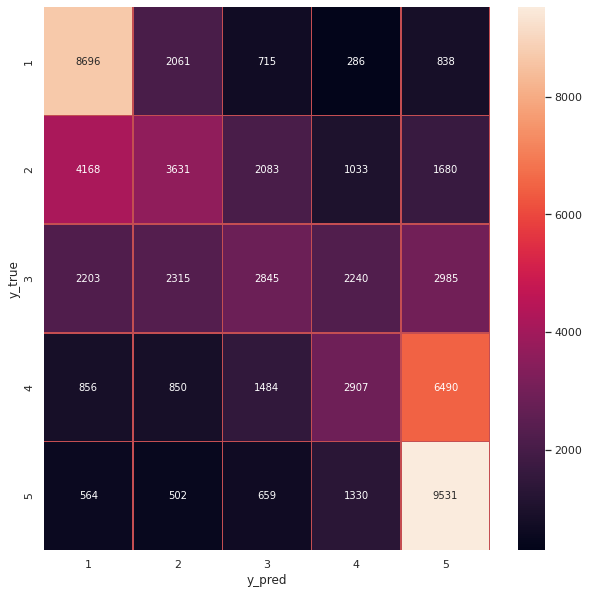

(0.44752393012268016, 0.4385881306392172)

In [ ]:
clf = GaussianNB()
clf.fit(X_train_cl,ytrain_cl)
evaluar_modelo(clf ,X_train_cl ,X_test_cl ,ytrain_cl ,ytest_cl)

### Linear SVC

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=20, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Accuracy en train:  0.5063
Accuracy en test:  0.4892
              precision    recall  f1-score   support

           1       0.57      0.73      0.64     12596
           2       0.41      0.36      0.38     12595
           3       0.41      0.30      0.35     12588
           4       0.44      0.35      0.39     12587
           5       0.54      0.71      0.61     12586

    accuracy                           0.49     62952
   macro avg       0.47      0.49      0.47     62952
weighted avg       0.47      0.49      0.47     62952



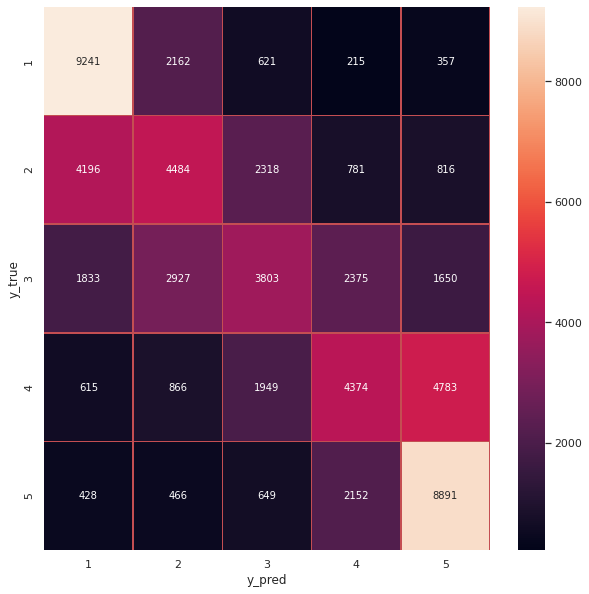

(0.5063314407091214, 0.48915046384546956)

In [ ]:
clf = LinearSVC(C = 20, max_iter= 500)
clf.fit(X_train_cl,ytrain_cl)
evaluar_modelo(clf ,X_train_cl ,X_test_cl ,ytrain_cl ,ytest_cl)

### **Random Forest**

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy en train:  0.4581
Accuracy en test:  0.4218
              precision    recall  f1-score   support

           1       0.55      0.65      0.59     12596
           2       0.34      0.29      0.31     12595
           3       0.38      0.19      0.25     12588
           4       0.39      0.27      0.32     12587
           5       0.40      0.71      0.51     12586

    accuracy                           0.42     62952
   macro avg       0.4

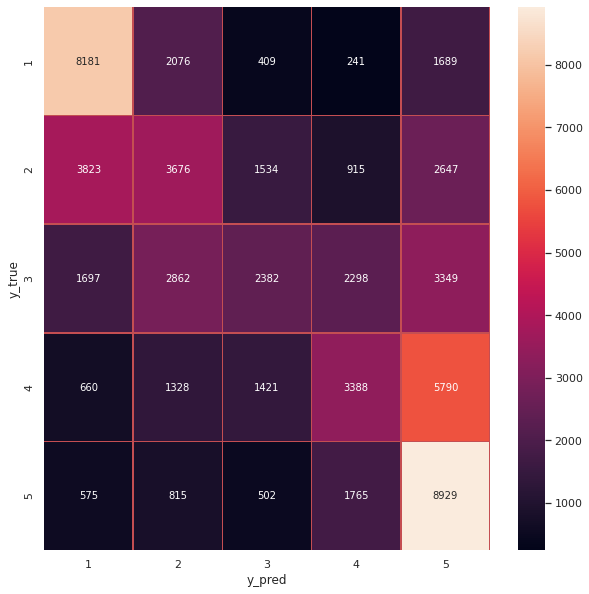

(0.4581444113121741, 0.4218452154022112)

In [ ]:
clf = RandomForestClassifier(max_depth= 14)
clf.fit(X_train_cl,ytrain_cl)
evaluar_modelo(clf ,X_train_cl ,X_test_cl ,ytrain_cl ,ytest_cl)

In [ ]:
print(classification_report(ytest_cl, y_pred))

              precision    recall  f1-score   support

           1       0.54      0.65      0.59     12596
           2       0.35      0.27      0.30     12595
           3       0.38      0.23      0.29     12588
           4       0.40      0.28      0.33     12587
           5       0.41      0.70      0.52     12586

    accuracy                           0.43     62952
   macro avg       0.42      0.43      0.41     62952
weighted avg       0.42      0.43      0.41     62952



## **Data Stemmatizada**

In [ ]:
#Definimos el vectorizador para Data_Stemmatizasa ('review_body_stemm')
tfidf_st = tfidf_st.fit(X_train_st)
X_train_st = tfidf_st.transform(X_train_st).toarray()
X_test_st = tfidf_st.transform(X_test_st).toarray()

### **Naive Bayes - Benchmark**

GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy en train:  0.4308
Accuracy en test:  0.4174
              precision    recall  f1-score   support

           1       0.49      0.69      0.57     12596
           2       0.36      0.28      0.32     12595
           3       0.33      0.20      0.25     12588
           4       0.36      0.23      0.28     12587
           5       0.44      0.69      0.53     12586

    accuracy                           0.42     62952
   macro avg       0.40      0.42      0.39     62952
weighted avg       0.40      0.42      0.39     62952



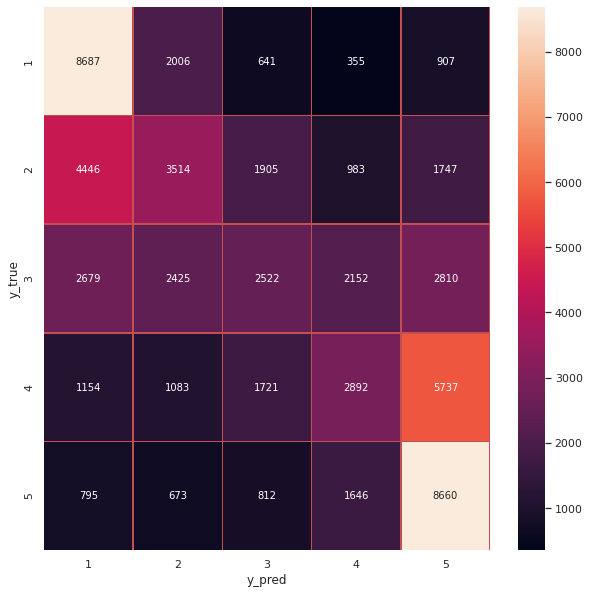

(0.43083071225303976, 0.41738149701359767)

In [ ]:
clf = GaussianNB()
clf.fit(X_train_st,ytrain_st)
evaluar_modelo(clf ,X_train_st ,X_test_st ,ytrain_st ,ytest_st)

### **Linear SVC**

LinearSVC(C=20, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Accuracy en train:  0.4935
Accuracy en test:  0.4763
              precision    recall  f1-score   support

           1       0.56      0.72      0.63     12596
           2       0.40      0.34      0.37     12595
           3       0.39      0.30      0.34     12588
           4       0.43      0.33      0.37     12587
           5       0.53      0.69      0.60     12586

    accuracy                           0.48     62952
   macro avg       0.46      0.48      0.46     62952
weighted avg       0.46      0.48      0.46     62952



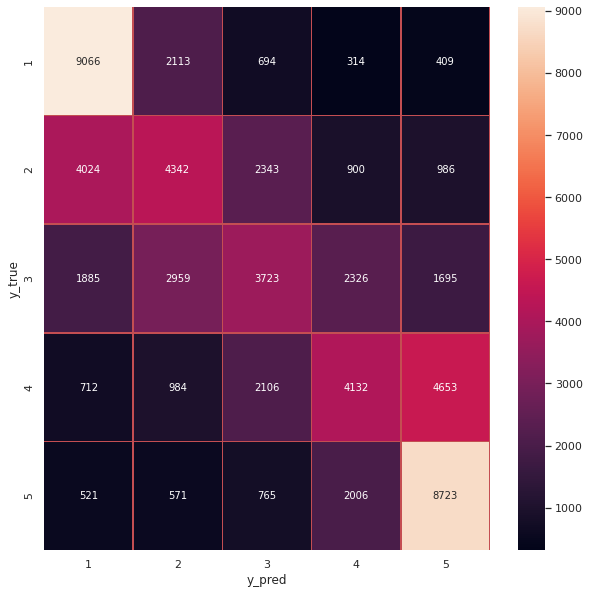

(0.4935187832741037, 0.4763311729571737)

In [ ]:
clf = LinearSVC(C = 20, max_iter= 500)
clf.fit(X_train_st,ytrain_st)
evaluar_modelo(clf ,X_train_st ,X_test_st ,ytrain_st ,ytest_st)

### **Random Forest**

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy en train:  0.4639
Accuracy en test:  0.424
              precision    recall  f1-score   support

           1       0.53      0.66      0.59     12596
           2       0.30      0.35      0.32     12595
           3       0.34      0.28      0.31     12588
           4       0.42      0.24      0.31     12587
           5       0.50      0.58      0.54     12586

    accuracy                           0.42     62952
   macro avg       0.42

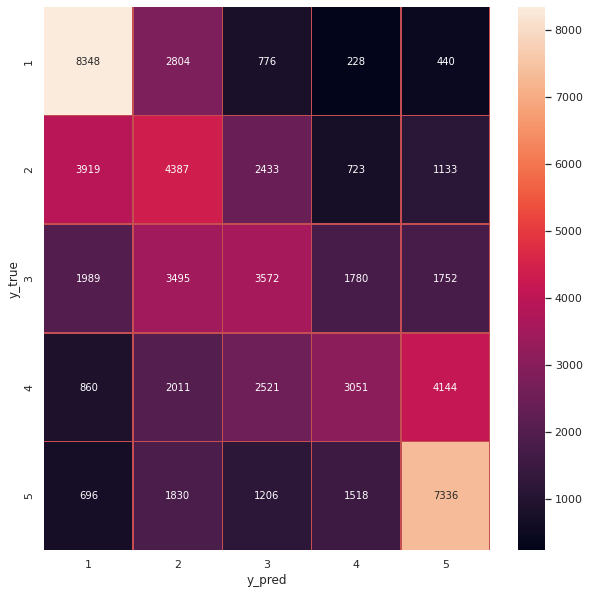

(0.4638563239519083, 0.4240373617994663)

In [ ]:
clf = RandomForestClassifier(max_depth= 14)
clf.fit(X_train_st,ytrain_st)
evaluar_modelo(clf ,X_train_st ,X_test_st ,ytrain_st ,ytest_st)

In [ ]:
print(classification_report(ytest_st, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.67      0.62     12596
           2       0.36      0.34      0.35     12595
           3       0.35      0.30      0.32     12588
           4       0.39      0.35      0.37     12587
           5       0.52      0.59      0.56     12586

    accuracy                           0.45     62952
   macro avg       0.44      0.45      0.44     62952
weighted avg       0.44      0.45      0.44     62952



## **Data Lemmatizada**

In [ ]:
#Definimos el vectorizador para Data_Stemmatizasa ('review_body_stemm')
tfidf_le = tfidf_le.fit(X_train_le)
X_train_le = tfidf_le.transform(X_train_le).toarray()
X_test_le = tfidf_le.transform(X_test_le).toarray()

### **Naive Bayes - Benchmark**

GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy en train:  0.4153
Accuracy en test:  0.3977
              precision    recall  f1-score   support

           1       0.48      0.65      0.55     12596
           2       0.35      0.26      0.29     12595
           3       0.31      0.19      0.24     12588
           4       0.34      0.20      0.25     12587
           5       0.40      0.69      0.51     12586

    accuracy                           0.40     62952
   macro avg       0.38      0.40      0.37     62952
weighted avg       0.38      0.40      0.37     62952



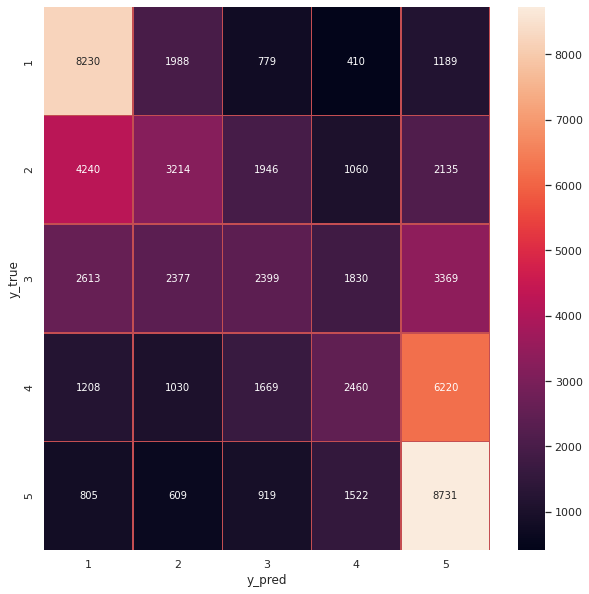

(0.4153288945168362, 0.3976680645571229)

In [ ]:
clf = GaussianNB()
clf.fit(X_train_le,ytrain_le)
evaluar_modelo(clf ,X_train_le ,X_test_le ,ytrain_le ,ytest_le)

In [ ]:
print(classification_report(ytest_le, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.65      0.55     12596
           2       0.35      0.26      0.29     12595
           3       0.31      0.19      0.24     12588
           4       0.34      0.20      0.25     12587
           5       0.40      0.69      0.51     12586

    accuracy                           0.40     62952
   macro avg       0.38      0.40      0.37     62952
weighted avg       0.38      0.40      0.37     62952



### **Linear SVC**

LinearSVC(C=20, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Accuracy en train:  0.4681
Accuracy en test:  0.4487
              precision    recall  f1-score   support

           1       0.54      0.67      0.60     12596
           2       0.37      0.34      0.35     12595
           3       0.35      0.28      0.31     12588
           4       0.40      0.29      0.34     12587
           5       0.50      0.66      0.57     12586

    accuracy                           0.45     62952
   macro avg       0.43      0.45      0.43     62952
weighted avg       0.43      0.45      0.43     62952



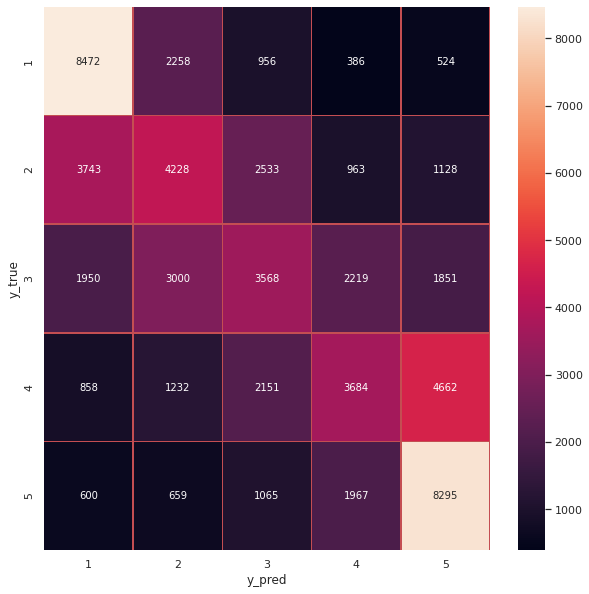

(0.4681113244284683, 0.44870695132799593)

In [ ]:
clf = LinearSVC(C = 20, max_iter= 500)
clf.fit(X_train_le,ytrain_le)
evaluar_modelo(clf ,X_train_le ,X_test_le ,ytrain_le ,ytest_le)

### **Random Forest**

In [ ]:
clf = RandomForestClassifier(n_estimators = 50, random_state=42,max_depth = 14)
clf.fit(X_train_le,ytrain_le)
evaluar_modelo(clf ,X_train_le ,X_test_le ,ytrain_le ,ytest_le)

## **Elección del Modelo y conjunto de Datos**

El mejor modelo es Linear SVC con Data clean

LinearSVC(C=20, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Accuracy en train:  0.5064
Accuracy en test:  0.489
              precision    recall  f1-score   support

           1       0.57      0.73      0.64     12596
           2       0.41      0.36      0.38     12595
           3       0.41      0.30      0.35     12588
           4       0.44      0.35      0.39     12587
           5       0.54      0.71      0.61     12586

    accuracy                           0.49     62952
   macro avg       0.47      0.49      0.47     62952
weighted avg       0.47      0.49      0.47     62952



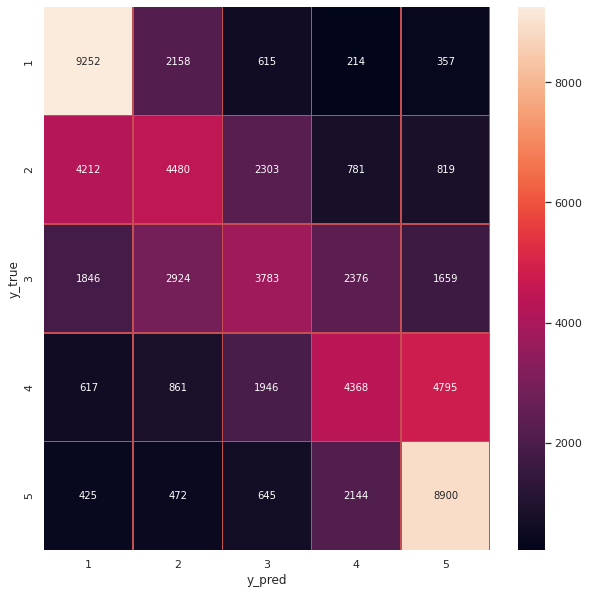

(0.5063518647114088, 0.48899161265726265)

In [17]:
clf = LinearSVC(C = 20, max_iter= 500)
clf.fit(X_train_cl,ytrain_cl)
evaluar_modelo(clf ,X_train_cl ,X_test_cl ,ytrain_cl ,ytest_cl)

## **Optimización de Hiperparámetros**

Ahora que tenemos definidos nuestro conjunto de datos normalizados a utilizar (`Data_clean - 'review_body'`) y el modelo (`Linear SVC`), voy a optimizar los hiperparámetros para maximizar el performance.

Voy a ejecutar 4 optimizaciones:

1. `Dos Grid Search`
2. `Dos Randomized Search`


### **GridSearch**

GridSearch 1

In [ ]:
#Grid Search 1
param_grid = {'C':[0.01,0.1,1,1.1]}
svcgs = LinearSVC()
model = GridSearchCV(svcgs, param_grid=param_grid,cv=5)
model.fit(X_train_cl,ytrain_cl)

print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores parametros: {'C': 1.1}
Mejor Score: 0.4895633207857365



LinearSVC(C=1.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Accuracy en train:  0.5063
Accuracy en test:  0.4889
              precision    recall  f1-score   support

           1       0.57      0.73      0.64     12596
           2       0.41      0.36      0.38     12595
           3       0.41      0.30      0.35     12588
           4       0.44      0.35      0.39     12587
           5       0.54      0.71      0.61     12586

    accuracy                           0.49     62952
   macro avg       0.47      0.49      0.47     62952
weighted avg       0.47      0.49      0.47     62952



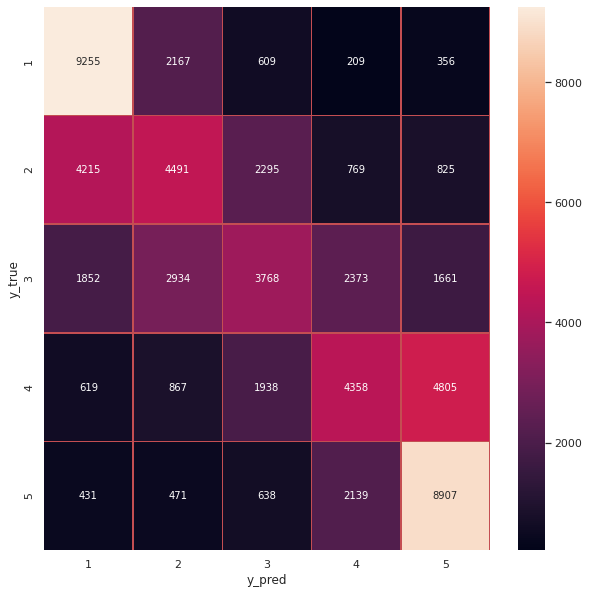

(0.5062837847037839, 0.4889280721819799)

In [23]:
#GridSearch
clf = LinearSVC(C = 1.1, max_iter= 500)
clf.fit(X_train_cl,ytrain_cl)
evaluar_modelo(clf ,X_train_cl ,X_test_cl ,ytrain_cl ,ytest_cl)

In [24]:
#CrossVal para GS1 
results = cross_validate(clf, X_train_cl, ytrain_cl, cv=5, return_train_score=True, scoring='accuracy', n_jobs=-1)
print('Mean r2 test: ', np.mean(results['test_score']))

Mean r2 test:  0.4895633207857365


Grid Search 2

In [ ]:
#Grid Search 2
param_grid = {'C':[1,1.5,2,2.5,3]}
svcgs = LinearSVC()
model = GridSearchCV(svcgs, param_grid=param_grid,cv=5)
model.fit(X_train_cl,ytrain_cl)

print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores parametros: {'C': 2.5}
Mejor Score: 0.48957012952806717



LinearSVC(C=2.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Accuracy en train:  0.5063
Accuracy en test:  0.4889
              precision    recall  f1-score   support

           1       0.57      0.73      0.64     12596
           2       0.41      0.36      0.38     12595
           3       0.41      0.30      0.35     12588
           4       0.44      0.35      0.39     12587
           5       0.54      0.71      0.61     12586

    accuracy                           0.49     62952
   macro avg       0.47      0.49      0.47     62952
weighted avg       0.47      0.49      0.47     62952



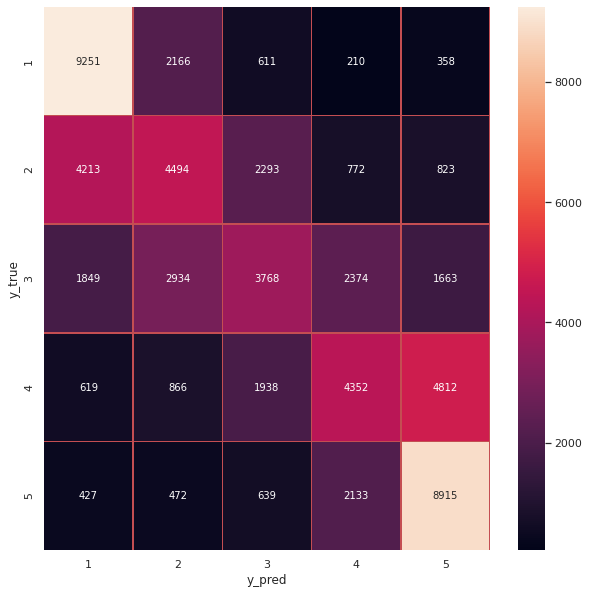

(0.5062701687022589, 0.4889439573008006)

In [27]:
#GridSearch
clf = LinearSVC(C = 2.5, max_iter= 500)
clf.fit(X_train_cl,ytrain_cl)
evaluar_modelo(clf ,X_train_cl ,X_test_cl ,ytrain_cl ,ytest_cl)

In [28]:
#CrossVal para RS1 
results = cross_validate(clf, X_train_cl, ytrain_cl, cv=5, return_train_score=True, scoring='accuracy', n_jobs=-1)
print('Mean r2 test: ', np.mean(results['test_score']))

Mean r2 test:  0.48956332148095544


### RandomSearch

In [ ]:
#Randomized Search 1
#fijamos seed = 0
svc_o = LinearSVC(dual = False,
                  random_state= 0)

#Parámetros para  RandomizedSearchCV
params = {  'penalty': ['l1', 'l2'],              #norma de regularizacion
             'loss' : ['hinge', 'squared_hinge'], #tipo función de pérdida
             'tol': [1e-3, 1e-4, 1e-5],           #tolerancia para el error
             'C': [10, 20, 50],                   #parámetro clave del modelo SVC
             'max_iter': [500, 1000]              #número máximo de iteraciones 
         }
                 
svc_rs = RandomizedSearchCV( estimator = svc_o, 
                             param_distributions = params, 
                             n_iter = 15, 
                             cv = 5,               #crossvalidation de 5-folds
                             scoring = 'accuracy'
                            )


svc_rs.fit(X_train_cl,ytrain_cl)

print('Los mejores parámetros son:', svc_rs.best_params_, '\n')
print('El mejor score es:', svc_rs.best_score_)

Los mejores parámetros son: {'tol': 0.001, 'penalty': 'l2', 'max_iter': 500, 'loss': 'squared_hinge', 'C': 10} 

El mejor score es: 0.48949524216853674


LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)
Accuracy en train:  0.5064
Accuracy en test:  0.4891
              precision    recall  f1-score   support

           1       0.57      0.73      0.64     12596
           2       0.41      0.36      0.38     12595
           3       0.41      0.30      0.35     12588
           4       0.44      0.35      0.39     12587
           5       0.54      0.71      0.61     12586

    accuracy                           0.49     62952
   macro avg       0.47      0.49      0.47     62952
weighted avg       0.47      0.49      0.47     62952



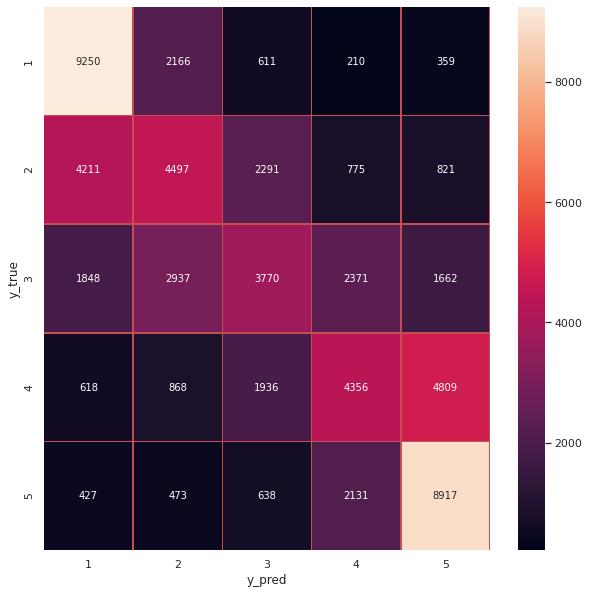

(0.5063518647114088, 0.4891028084890075)

In [19]:
#RandomizedSearch
clf = LinearSVC(tol = 0.001, penalty = 'l2', max_iter = 500, loss= 'squared_hinge', C = 10)
clf.fit(X_train_cl,ytrain_cl)
evaluar_modelo(clf ,X_train_cl ,X_test_cl ,ytrain_cl ,ytest_cl)

In [22]:
#CrossVal para RS1 
results = cross_validate(clf, X_train_cl, ytrain_cl, cv=5, return_train_score=True, scoring='accuracy', n_jobs=-1)
print('Mean r2 test: ', np.mean(results['test_score']))

Mean r2 test:  0.4894475858387549


In [ ]:
#Randomized Search 2
#fijamos seed = 0
svc_o = LinearSVC(dual = False,
                  random_state= 0)

#Parámetros para  RandomizedSearchCV
params = {  'penalty': ['l1', 'l2'],              #norma de regularizacion
             'loss' : ['hinge', 'squared_hinge'], #tipo función de pérdida
             'fit_intercept': ['True','False'],   #Intercepción del modelo
             'C': [10, 20, 50],                   #parámetro clave del modelo SVC
             'multi_class': ['ovr', 'crammer_singer']     #Determina qué estratégia se usa para dividir las multiclases 
         }
                 
svc_rs = RandomizedSearchCV( estimator = svc_o, 
                             param_distributions = params, 
                             n_iter = 15, 
                             cv = 5,               #crossvalidation de 5-folds
                             scoring = 'accuracy'
                            )


svc_rs.fit(X_train_cl,ytrain_cl)

print('Los mejores parámetros son:', svc_rs.best_params_, '\n')
print('El mejor score es:', svc_rs.best_score_)

### **Modelo Final**

El modelo final es un Linear SVC, con el hiperparámetro de `C = 2.5`.


LinearSVC(C=2.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Accuracy en train:  0.5063
Accuracy en test:  0.4889
              precision    recall  f1-score   support

           1       0.57      0.73      0.64     12596
           2       0.41      0.36      0.38     12595
           3       0.41      0.30      0.35     12588
           4       0.44      0.35      0.39     12587
           5       0.54      0.71      0.61     12586

    accuracy                           0.49     62952
   macro avg       0.47      0.49      0.47     62952
weighted avg       0.47      0.49      0.47     62952



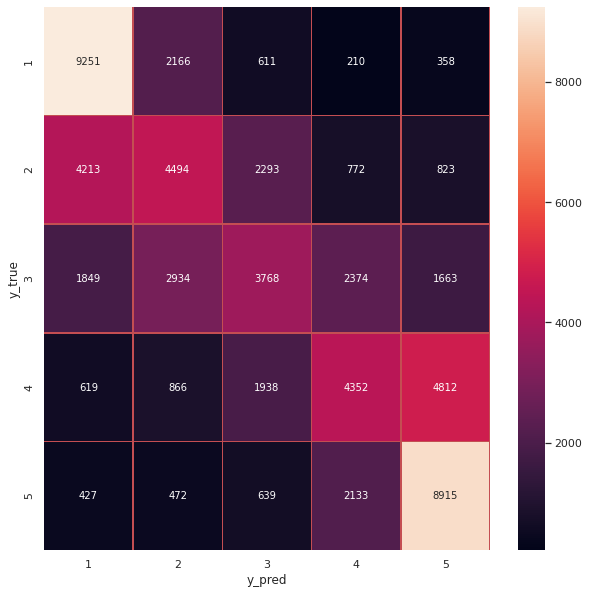

(0.5062633607014964, 0.4889439573008006)

In [30]:
#GridSearch
clf = LinearSVC(C = 2.5, max_iter= 500)
clf.fit(X_train_cl,ytrain_cl)
evaluar_modelo(clf ,X_train_cl ,X_test_cl ,ytrain_cl ,ytest_cl)

In [32]:
results = cross_validate(clf, X_train_cl, ytrain_cl, cv=8, return_train_score=True, scoring='accuracy', n_jobs=-1)
print('Mean r2 test: ', round(np.mean(results['test_score']),2))

Mean r2 test:  0.49


Luego de hacer un cross-validation, podemos ver que el accuracy de 8 folds, será igual al 49%

## **5- Conclusiones**

Para terminar este trabajo, me gustaría tocar los siguientes puntos:

En cuanto a a la `normalización` de nuestros datos, me sorprendió ver que las tecnicas de Stemming y Lemmatization no fueron capaces de generar mejores features para nuestro modelo, ya que la Data preprocesada simple, fue la que mejores métricas generó.

Por otra parte, la `vectorización` de nuestros datos siento que puede ser mejor desde dos puntos:


  1. Si tomamos únicamente comentarios sobre la misma 'product_category' quizás pueda generar en la vectorización un corpus más robusto, en donde si se le den importancia a las palabras clave de ese mundo. 
  
  Me imagino como ejemplo, el hecho de que en el comentario diga -`hace mucho ruido`- puede significar dos cosas totalmente contrarias según la categoría de productos. En la categoría `electronics` puede ser un atributo muy **positivo** para un parlante. Mientras que para la categoría de `kitchen`, una licuadora que haga mucho ruido puede ser algo muy **negativo**.

  2. Por otro lado, quizás probar con un metodo de vectorización más robusto como un word embbedding puede ser favorecedor para nuestro modelo.

Por último, si bien el modelo fue bastante impreciso en la `clasificación  multiclase`, quizás si modificamos la problemática a un problema `binario`, la precisión podría mejorar rotundamente.


Para avanzar con este proyecto,tengo como objetivo probar nuevas técnicas de normalizado, afinar desde ese lado los datos. Por otro lado, probar ambos puntos mencionados en el apartado de vectorización, y finalmente, probar el problema, modelandolo como una cuestión binaria (positivo o negativo).